In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from xgboost import plot_importance
import joblib

In [2]:
# Load the dataset
dataset = pd.read_excel('inputs/data.xlsx', sheet_name='Hoja1')

# Remove any trailing spaces from column names
dataset.columns = dataset.columns.str.strip()

# Take a portion of the dataset from training
data = dataset.iloc[200:400]

# Number of assets
num_assets = len(data)

# Reset index for iterations
data.index = range(num_assets)

# Save mean values
mean_des = round(data['Desirability'].mean(), 2)
mean_sus = round(data['Sustainability'].mean(), 2)
mean_fea = round(data['Feasibility'].mean(), 2)
#print(mean_des, mean_sus, mean_fea)

FileNotFoundError: [Errno 2] No such file or directory: 'inputs/data.xlsx'

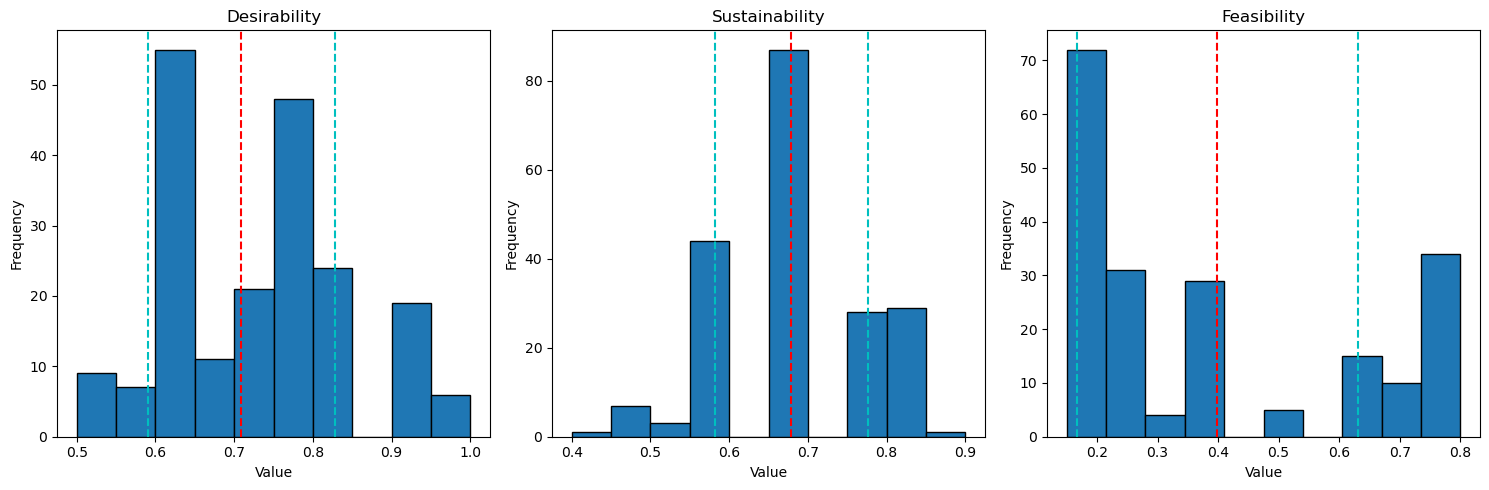

In [50]:
# Check columns distribution
columns = ['Desirability', 'Sustainability', 'Feasibility']
titles = ["Desirability", "Sustainability", "Feasibility"]

plt.figure(figsize=(15, 5))

for i, column in enumerate(columns):
    plt.subplot(1, 3, i+1)
    plt.hist(data[column], bins=10, edgecolor='k')
    
    stats = data[column].describe()
    plt.axvline(stats['mean'], color='r', linestyle='dashed')
    plt.axvline(stats['mean'] + stats['std'], color='c', linestyle='dashed')
    plt.axvline(stats['mean'] - stats['std'], color='c', linestyle='dashed')
    
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.title(titles[i])

plt.tight_layout()
plt.show()

In [51]:
# Adjust synergy based on the rules
def synergy_rules_dsf(asset_A, asset_B, mean_value, synergy):
    if asset_A > mean_value and asset_B > mean_value:
        synergy += 0.4
    elif asset_A < mean_value and asset_B < mean_value:
        synergy -= 0.4
    elif asset_A > mean_value and asset_B < mean_value:
        synergy += 0.3
    elif asset_A < mean_value and asset_B > mean_value:
        synergy -= 0.3

    # Special cases
    elif asset_A == mean_value and asset_B > mean_value:
        synergy += 0.2
    elif asset_A == mean_value and asset_B < mean_value:
        synergy -= 0.2
    elif asset_A > mean_value and asset_B == mean_value:
        synergy += 0.2
    elif asset_A < mean_value and asset_B == mean_value:
        synergy -= 0.2
    elif asset_A == mean_value and asset_B == mean_value:
        if asset_A > 0.5:
            synergy += 0.2
        else:
            synergy -= 0.2
    
    return synergy

# Calculate the synergy between two assets
def calculate_synergy(asset1, asset2, df):
    synergy = 1
    
    # Get features from assets 1 and 2
    asset1_info = df.loc[asset1]
    asset2_info = df.loc[asset2]

    # Calculate synergy between asset1 and asset2
    synergy = synergy_rules_dsf(asset1_info['Desirability'], asset2_info['Desirability'], mean_des, synergy)
    synergy = synergy_rules_dsf(asset1_info['Sustainability'], asset2_info['Sustainability'], mean_sus, synergy)
    synergy = synergy_rules_dsf(asset1_info['Feasibility'], asset2_info['Feasibility'], mean_fea, synergy)

    return synergy

In [52]:
# Convert the data for training
df = []

for i in range(num_assets-1):
    j = i + 1
    synergy = calculate_synergy(i, j, data)
    
    row = {
        'Asset_A_Desirability': data.loc[i, 'Desirability'],
        'Asset_A_Sustainability': data.loc[i, 'Sustainability'],
        'Asset_A_Feasibility': data.loc[i, 'Feasibility'],
        'Asset_B_Desirability': data.loc[j, 'Desirability'],
        'Asset_B_Sustainability': data.loc[j, 'Sustainability'],
        'Asset_B_Feasibility': data.loc[j, 'Feasibility'],
        'Synergy': synergy
    }
    
    df.append(row)

df_model = pd.DataFrame(df)
df_training = df_model.drop_duplicates()
len(df_training)

188

In [53]:
''' Model training - Calculate synergy between two asset '''

# Split the predictive features (X) and the target (y)
X = df_training.drop(columns=['Synergy'])
y = df_training['Synergy']

# Split the data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model to predict synergy effects
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping_rounds=10) 

# Note: The best performing model as defined on the validation set is stored and when making predictions with the fit model will use the model stored
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Make predictions using the best model
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Calculate R-squared for train and test data
r_sq_train = r2_score(y_train, xgb_train_pred)
r_sq_val = r2_score(y_val, xgb_val_pred)
r_sq_test = r2_score(y_test, xgb_test_pred)

# Show results
print(f'Best score {xgb_model.best_score}, Best iteration {xgb_model.best_iteration}')
print("R-sq for train data:", r_sq_train)
print("R-sq for val data:", r_sq_val)
print("R-sq for test data:", r_sq_test)

[0]	validation_0-rmse:0.50160
[1]	validation_0-rmse:0.45955
[2]	validation_0-rmse:0.42227
[3]	validation_0-rmse:0.38823
[4]	validation_0-rmse:0.35805
[5]	validation_0-rmse:0.32862
[6]	validation_0-rmse:0.30192
[7]	validation_0-rmse:0.27767
[8]	validation_0-rmse:0.25705
[9]	validation_0-rmse:0.23724
[10]	validation_0-rmse:0.21971
[11]	validation_0-rmse:0.20446
[12]	validation_0-rmse:0.19052
[13]	validation_0-rmse:0.17834
[14]	validation_0-rmse:0.16692
[15]	validation_0-rmse:0.15699
[16]	validation_0-rmse:0.14786
[17]	validation_0-rmse:0.14019
[18]	validation_0-rmse:0.13275
[19]	validation_0-rmse:0.12649
[20]	validation_0-rmse:0.12069
[21]	validation_0-rmse:0.11538
[22]	validation_0-rmse:0.11115
[23]	validation_0-rmse:0.10749
[24]	validation_0-rmse:0.10421
[25]	validation_0-rmse:0.10075
[26]	validation_0-rmse:0.09809
[27]	validation_0-rmse:0.09570
[28]	validation_0-rmse:0.09410
[29]	validation_0-rmse:0.09235
[30]	validation_0-rmse:0.09073
[31]	validation_0-rmse:0.08948
[32]	validation_0-

In [57]:
# Save trained model
joblib.dump(xgb_model, 'XGB_model.sav')

['XGB_model.sav']